In [17]:
"""
A compact, readable Revised Simplex implementation (LU-based) intended
for educational / small-scale testing. It intentionally rebuilds the LU
factorization after each pivot for simplicity and numerical robustness.

API:
    RevisedSimplex(A, b, c, B_init, tol=1e-12, sense='max')
    -> .solve(max_iters=1000) -> dict with keys:
       - status: 'optimal' / 'unbounded' / 'max_iters' / 'error'
       - x: solution vector (when available)
       - objective: float (when available)
       - iterations: number of pivots performed
       - rebuilds: number of LU rebuilds
       - B_idx: final basis indices (list)
"""
from __future__ import annotations
from typing import List, Sequence, Dict, Any, Optional
import numpy as np

try:
    from scipy.linalg import lu_factor, lu_solve
except Exception as e:
    raise ImportError("scipy.linalg.lu_factor and lu_solve are required") from e


class RevisedSimplex:
    def __init__(
        self,
        A: np.ndarray,
        b: np.ndarray,
        c: np.ndarray,
        B_init: Sequence[int],
        tol: float = 1e-12,
        sense: str = "max",
    ):
        A = np.asarray(A, dtype=float)
        b = np.asarray(b, dtype=float)
        c = np.asarray(c, dtype=float)
        m, n = A.shape
        if b.shape[0] != m:
            raise ValueError("Incompatible dimensions: b must have length m")
        if c.shape[0] != n:
            raise ValueError("Incompatible dimensions: c must have length n")
        if len(B_init) != m:
            raise ValueError("B_init must have length m (one basic index per row)")

        self.A = A
        self.b = b
        self.c = c
        self.m = m
        self.n = n
        self.tol = float(tol)
        if sense not in ("max", "min"):
            raise ValueError("sense must be 'max' or 'min'")
        self.sense = sense

        # index lists
        self.B_idx: List[int] = list(int(i) for i in B_init)
        self.N_idx: List[int] = [j for j in range(n) if j not in self.B_idx]

        # state
        self.iterations = 0
        self.rebuilds = 0
        self._rebuild_basis()

    # -------------------------
    def _rebuild_basis(self) -> None:
        """Rebuild LU factorization of the current basis and compute x_B."""
        B = self.A[:, self.B_idx]
        # LU factorization (with partial pivoting)
        self.lu_and_piv = lu_factor(B)
        self.rebuilds += 1
        # Solve B x_B = b
        self.xB = lu_solve(self.lu_and_piv, self.b)

        # basis cost
        self.cB = self.c[self.B_idx]

    def _reduced_costs_and_dual(self):
        """Return (red, y) where red is reduced costs for nonbasics and y is dual."""
        # Solve B^T y = cB  -> use trans=1 in lu_solve
        y = lu_solve(self.lu_and_piv, self.cB, trans=1)
        AN = self.A[:, self.N_idx]
        cN = self.c[self.N_idx]
        red = cN - AN.T.dot(y)
        return red, y

    def _choose_entering(self, red: np.ndarray) -> Optional[int]:
        """Return local index into N_idx of the entering variable, or None if optimal."""
        if self.sense == "max":
            idx = int(np.argmax(red))
            if red[idx] <= self.tol:
                return None
            return idx
        else:  # minimization
            idx = int(np.argmin(red))
            if red[idx] >= -self.tol:
                return None
            return idx

    def _ratio_test(self, d: np.ndarray) -> Optional[int]:
        """Given direction d = B^{-1} a_q, return local leaving index into B_idx or None if unbounded."""
        pos = d > self.tol
        if not np.any(pos):
            return None
        ratios = np.full(d.shape, np.inf)
        ratios[pos] = self.xB[pos] / d[pos]
        # pick smallest ratio; ties: pick first (can improve to Bland later)
        leave_local = int(np.argmin(ratios))
        return leave_local

    def iterate_once(self):
        """Perform a single pivot iteration. Return status and bookkeeping info."""
        red, y = self._reduced_costs_and_dual()
        entering_local = self._choose_entering(red)
        if entering_local is None:
            return "optimal", None, None

        q = self.N_idx[entering_local]
        a_q = self.A[:, q]
        d = lu_solve(self.lu_and_piv, a_q)  # solve B d = a_q

        # unbounded?
        leave_local = self._ratio_test(d)
        if leave_local is None:
            return "unbounded", q, d

        # pivot: replace leaving basis by entering
        p = self.B_idx[leave_local]
        self.B_idx[leave_local] = q
        self.N_idx[entering_local] = p

        # rebuild basis data (simple strategy)
        self._rebuild_basis()
        self.iterations += 1
        return "continue", p, q

    def solve(self, max_iters: int = 1000) -> Dict[str, Any]:
        """Run simplex until termination or max_iters. Returns result dict."""
        try:
            for _ in range(max_iters):
                status, p, q = self.iterate_once()
                if status == "optimal":
                    # produce full x
                    x = np.zeros(self.n, dtype=float)
                    for i, bi in enumerate(self.B_idx):
                        x[bi] = float(self.xB[i])
                    obj = float(self.c.dot(x))
                    return {
                        "status": "optimal",
                        "x": x,
                        "objective": obj,
                        "iterations": int(self.iterations),
                        "rebuilds": int(self.rebuilds),
                        "B_idx": list(self.B_idx),
                    }
                if status == "unbounded":
                    return {
                        "status": "unbounded",
                        "entering": int(p) if p is not None else None,
                        "iterations": int(self.iterations),
                        "rebuilds": int(self.rebuilds),
                    }
            # reached max iters
            return {"status": "max_iters", "iterations": int(self.iterations), "rebuilds": int(self.rebuilds)}
        except Exception as e:
            return {"status": "error", "error": str(e), "iterations": int(self.iterations), "rebuilds": int(self.rebuilds)}


In [18]:
"""
run_experiments.py (updated)

Usage:
    python run_experiments.py [--repeats N] [--warmup M] [--results PATH]

Behavior:
- Produces: results/summary.csv and results/<problem>_<solver>_run<N>.json
- By default, "results" is created as a sibling to the directory that contains this script.
  (So if this file lives in "code/", results will be created next to "code/".)
"""

'\nrun_experiments.py (updated)\n\nUsage:\n    python run_experiments.py [--repeats N] [--warmup M] [--results PATH]\n\nBehavior:\n- Produces: results/summary.csv and results/<problem>_<solver>_run<N>.json\n- By default, "results" is created as a sibling to the directory that contains this script.\n  (So if this file lives in "code/", results will be created next to "code/".)\n'

In [19]:
from __future__ import annotations
import argparse
import csv
import json
import logging
import time
import traceback
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Sequence

import numbers
import numpy as np


In [20]:
logger = logging.getLogger("run_experiments")
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")


In [21]:
def to_jsonable(obj: Any) -> Any:
    """
    Recursively convert numpy types (ndarray, numpy scalars) to Python built-ins
    so the structure becomes JSON-serializable.
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.floating, np.integer, np.bool_)):
        return obj.item()
    if isinstance(obj, (numbers.Number, str, bool)) or obj is None:
        return obj
    if isinstance(obj, dict):
        return {str(k): to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_jsonable(v) for v in obj]
    try:
        return str(obj)
    except Exception:
        return repr(obj)


In [22]:
def safe_json_dump(obj: Any, path: Path, indent: int = 2) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf8") as f:
        json.dump(to_jsonable(obj), f, indent=indent, ensure_ascii=False)


In [23]:
# -------------------------
# Determine results directory
# -------------------------
def get_default_results_dir(script_path: Optional[Path] = None) -> Path:
    """
    Place 'results' directory as a sibling to the folder containing this script.
    Example:
        script: /home/user/project/code/run_experiments.py
        results -> /home/user/project/results
    """
    if script_path is None:
      try :
        script_path = Path(__file__).resolve()
      except NameError :
        script_path = Path.cwd()
    script_dir = script_path.resolve().parent
    parent = script_dir.parent
    return parent / "results"


In [24]:
# -------------------------
# Solver discovery & fallback
# -------------------------
# Try to import user's RevisedSimplex implementation if available.
try:
    import importlib

    RevisedSimplex = None
    try:
        spec = importlib.util.find_spec("code.revised_simplex")
        if spec:
            modu = importlib.import_module("code.revised_simplex")
            RevisedSimplex = getattr(modu, "RevisedSimplex", None)
    except Exception:
        RevisedSimplex = None
except Exception:
    RevisedSimplex = None

In [25]:
# Fallback small revised-simplex skeleton (keeps behavior similar to your previous fallback)
try:
    from scipy.linalg import lu_factor, lu_solve
except Exception:
    lu_factor = lu_solve = None  # will raise if used



In [26]:
class FallbackRevised:
    def __init__(
        self,
        A: np.ndarray,
        b: np.ndarray,
        c: np.ndarray,
        B_init: Sequence[int],
        tol: float = 1e-12,
        sense: str = "max",
    ):
        self.A = A.copy().astype(float)
        self.b = b.copy().astype(float)
        self.c = c.copy().astype(float)
        self.m, self.n = A.shape
        self.B_idx = list(B_init)
        self.N_idx = [j for j in range(self.n) if j not in self.B_idx]
        self.tol = tol
        self.sense = sense  # 'max' or 'min'
        self.rebuilds = 0
        self.iterations = 0
        self._rebuild()

    def _rebuild(self):
        if lu_factor is None:
            raise RuntimeError("scipy.linalg.lu_factor is required by the fallback solver.")
        B = self.A[:, self.B_idx]
        self.lu, self.piv = lu_factor(B)
        self.xB = lu_solve((self.lu, self.piv), self.b)
        self.cB = self.c[self.B_idx]
        self.rebuilds += 1

    def _reduced(self):
        # compute reduced costs and dual
        y = lu_solve((self.lu, self.piv), self.cB, trans=1)
        red = self.c[self.N_idx] - self.A[:, self.N_idx].T.dot(y)
        return red, y

    def iterate_once(self):
        red, y = self._reduced()
        # For maximization: enter if max(reduced) > tol, choose argmax.
        # For minimization: enter if min(reduced) < -tol, choose argmin.
        if self.sense == "max":
            entering_local = int(np.argmax(red))
            if red[entering_local] <= self.tol:
                return "optimal", None, None
        else:  # 'min'
            entering_local = int(np.argmin(red))
            if red[entering_local] >= -self.tol:
                return "optimal", None, None

        q = self.N_idx[entering_local]
        a_q = self.A[:, q]
        d = lu_solve((self.lu, self.piv), a_q)
        pos = d > self.tol
        if not np.any(pos):
            return "unbounded", q, None
        ratios = np.full(d.shape, np.inf)
        ratios[pos] = self.xB[pos] / d[pos]
        leave_local = int(np.argmin(ratios))
        p = self.B_idx[leave_local]
        # swap indices
        self.B_idx[leave_local] = q
        self.N_idx[entering_local] = p
        self._rebuild()
        self.iterations += 1
        return "continue", p, q

    def solve(self, max_iters: int = 1000):
        for _ in range(max_iters):
            status, p, q = self.iterate_once()
            if status == "optimal":
                x = np.zeros(self.n)
                for i, bi in enumerate(self.B_idx):
                    x[bi] = self.xB[i]
                return {
                    "status": "optimal",
                    "x": x,
                    "objective": float(self.c.dot(x)),
                    "iterations": self.iterations,
                    "rebuilds": self.rebuilds,
                    "B_idx": list(self.B_idx),
                }
            if status == "unbounded":
                return {"status": "unbounded", "entering": q, "iterations": self.iterations, "rebuilds": self.rebuilds}
        return {"status": "max_iters", "iterations": self.iterations, "rebuilds": self.rebuilds}



In [27]:
def make_solver(A: np.ndarray, b: np.ndarray, c: np.ndarray, B_init: Sequence[int], sense: str = "max") -> Callable[[], Dict[str, Any]]:
    """
    Return a zero-arg function that runs the chosen solver and returns the result dict.
    Passes 'sense' to the fallback solver and attempts to pass it to a user RevisedSimplex if available.
    """
    if RevisedSimplex is not None:
        def run():
            # try to instantiate RevisedSimplex with a sense kwarg if supported, else without
            try:
                solver = RevisedSimplex(A, b, c, B_init, sense=sense)
            except TypeError:
                solver = RevisedSimplex(A, b, c, B_init)
            return solver.solve()
        return run
    else:
        def run():
            solver = FallbackRevised(A, b, c, B_init, sense=sense)
            return solver.solve()
        return run


In [28]:
@dataclass
class Problem:
    name: str
    A: np.ndarray
    b: np.ndarray
    c: np.ndarray
    B_init: List[int]
    sense: str = "max"  # 'max' or 'min' to indicate objective sense for SciPy wrapper



In [29]:
def build_problems() -> List[Problem]:
    problems: List[Problem] = []

    A1 = np.array([[1.0, 1.0, 1.0, 0.0], [1.0, 3.0, 0.0, 1.0]])
    b1 = np.array([4.0, 6.0])
    c1 = np.array([3.0, 2.0, 0.0, 0.0])
    B1 = [2, 3]
    problems.append(Problem("example1", A1, b1, c1, B1, sense="max"))

    A2 = np.array([[1, 1, -1, 0, 1, 0], [1, 2, 0, -1, 0, 1]], dtype=float)
    b2 = np.array([4.0, 5.0])
    # Phase I objective is a minimization of artificials a1+a2 -> sense='min'
    c2 = np.array([0.0, 0.0, 0.0, 0.0, 1.0, 1.0])
    B2 = [4, 5]
    problems.append(Problem("example2_phaseI", A2, b2, c2, B2, sense="min"))

    return problems



In [30]:
def run_scipy_highs(A: np.ndarray, b: np.ndarray, c: np.ndarray, sense: str = "max") -> Dict[str, Any]:
    """
    Run SciPy/HiGHS and return keys:
      - status: 'success'/'fail'/'scipy_missing'
      - x: solution vector (if any)
      - objective: objective value (c^T x using input c)
      - iterations: iteration count if provided by the solver (res.nit)
      - message: solver message

    The function respects `sense`: if sense=='max' we convert the objective to
    minimization by passing -c to linprog; if sense=='min' we pass c unchanged.
    """
    try:
        from scipy.optimize import linprog
        # convert objective according to sense
        c_min = -c if sense == "max" else c
        res = linprog(c_min, A_eq=A, b_eq=b, bounds=[(0, None)] * A.shape[1], method="highs")
        success = bool(getattr(res, "success", False))
        x = res.x if hasattr(res, "x") and res.x is not None else np.zeros(A.shape[1])
        obj = float(c.dot(x)) if x is not None else None
        iterations = getattr(res, "nit", None)
        message = getattr(res, "message", None)
        return {"status": "success" if success else "fail", "x": x, "objective": obj, "iterations": iterations, "message": message}
    except Exception as e:
        return {"status": "scipy_missing", "error": str(e)}


In [31]:
# -------------------------
# Helpers to make CSV rows complete
# -------------------------
def normalize_for_csv(val: Any) -> Any:
    """
    Convert None / nan to a readable placeholder '---'. Leave numbers as-is.
    """
    if val is None:
        return "---"
    if isinstance(val, float) and (np.isnan(val) or np.isinf(val)):
        return "---"
    if isinstance(val, (np.floating, np.integer)):
        return val.item()
    return val


In [32]:
from pathlib import Path
from typing import List, Dict, Any
import numpy as np
import time
import json
import csv
import traceback
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def run_all(repeats: int, warmup: int, results_dir: Path) -> None:
    results_dir.mkdir(parents=True, exist_ok=True)
    problems = build_problems()
    summary_rows: List[Dict[str, Any]] = []

    # Setup interactive plotting
    plt.ion()
    sns.set(style="whitegrid")

    for prob in problems:
        print(f"Running problem {prob.name}")
        solver_fn = make_solver(prob.A, prob.b, prob.c, prob.B_init, prob.sense)

        # warmup runs
        for _ in range(warmup):
            try:
                _ = solver_fn()
            except Exception:
                print(f"Warmup failed for {prob.name}")
                traceback.print_exc()

        # timed runs
        times: List[float] = []
        residuals: List[float] = []
        condBs: List[float] = []

        for i in range(repeats - warmup):
            t0 = time.perf_counter()
            try:
                out = solver_fn()
            except Exception as e:
                print(f"Solver failed on {prob.name}: {e}")
                traceback.print_exc()
                out = {"status": "error", "error": str(e)}
            t1 = time.perf_counter()
            elapsed = t1 - t0
            times.append(elapsed)

            # Handle solver output
            x = out.get("x", None)
            if x is not None:
                x = np.asarray(x, dtype=float)
                residual = float(np.max(np.abs(prob.A.dot(x) - prob.b)))
                residuals.append(residual)
                B_idx = out.get("B_idx", prob.B_init)
                try:
                    condB = float(np.linalg.cond(prob.A[:, B_idx])) if B_idx else np.nan
                except Exception:
                    condB = np.nan
                condBs.append(condB)
            else:
                residuals.append(np.nan)
                condBs.append(np.nan)

            # Save per-run JSON
            run_name = f"{prob.name}_revised_run{i+1}.json"
            safe_json_dump(
                {
                    "elapsed": elapsed,
                    "out": to_jsonable(out),
                    "objective": to_jsonable(out.get("objective", None)),
                    "residual": residuals[-1],
                    "condB": condBs[-1],
                },
                results_dir / run_name,
            )

            # ----------------------------
            # DYNAMIC LIVE PLOTTING
            # ----------------------------
            plt.clf()
            fig, ax = plt.subplots(2, 1, figsize=(10, 6))

            # Runtime line plot
            ax[0].plot(range(1, len(times)+1), times, marker='o', color='blue', label='Elapsed Time')
            ax[0].set_title(f"{prob.name} - Runtime Progress")
            ax[0].set_xlabel("Trial")
            ax[0].set_ylabel("Elapsed Time (s)")
            ax[0].legend()
            ax[0].grid(True)

            # Residual line plot
            ax[1].plot(range(1, len(residuals)+1), residuals, marker='x', color='red', label='Residual')
            ax[1].set_title(f"{prob.name} - Residual Progress")
            ax[1].set_xlabel("Trial")
            ax[1].set_ylabel("Residual (Ax-b)")
            ax[1].set_yscale("log")
            ax[1].legend()
            ax[1].grid(True)

            plt.tight_layout()
            plt.pause(0.1)  # brief pause to update plot

        # Summary row
        import statistics as stats
        med = float(stats.median(times)) if times else np.nan
        std = float(stats.pstdev(times) if len(times) > 1 else 0.0)

        summary_rows.append({
            "problem": prob.name,
            "solver": "revised",
            "obj": out.get("objective", np.nan),
            "residual": residuals[-1],
            "iterations": out.get("iterations", np.nan),
            "rebuilds": out.get("rebuilds", np.nan),
            "condB": condBs[-1],
            "time_median": med,
            "time_std": std,
            "trials": len(times)
        })

    plt.ioff()  # turn off interactive plotting

    # Final summary plots (all problems)
    df = pd.DataFrame(summary_rows)
    df['time_median'] = pd.to_numeric(df['time_median'], errors='coerce')
    df['residual'] = pd.to_numeric(df['residual'], errors='coerce')

    plt.figure(figsize=(12, 5))
    sns.barplot(data=df, x="problem", y="time_median", hue="solver", edgecolor='black')
    plt.title("Median Runtime per Problem")
    plt.ylabel("Time (s)")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.scatterplot(data=df, x="residual", y="time_median", hue="solver", s=100)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Residual vs Runtime")
    plt.xlabel("Residual (Ax-b)")
    plt.ylabel("Median Runtime (s)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [36]:
def parse_args(argv: Optional[Sequence[str]] = None) -> argparse.Namespace:
    p = argparse.ArgumentParser(description="Run revised simplex experiments.")
    p.add_argument("--repeats", "-r", type=int, default=6, help="Total repeats per problem (including warmup).")
    p.add_argument("--warmup", "-w", type=int, default=1, help="Number of warmup runs (not counted in measurements).")
    p.add_argument(
        "--results",
        "-o",
        type=Path,
        default=None,
        help="Path to results folder. By default placed as sibling to the folder containing this script.",
    )

    args, unknown = p.parse_known_args(argv)
    return args

2025-11-18 17:06:26,916 INFO Results directory: /home/omar-hazem/Learning_Courses/math303/Report1/results
/tmp/ipykernel_8006/4026521236.py:98: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1].set_yscale("log")


Running problem example1


<Figure size 640x480 with 0 Axes>

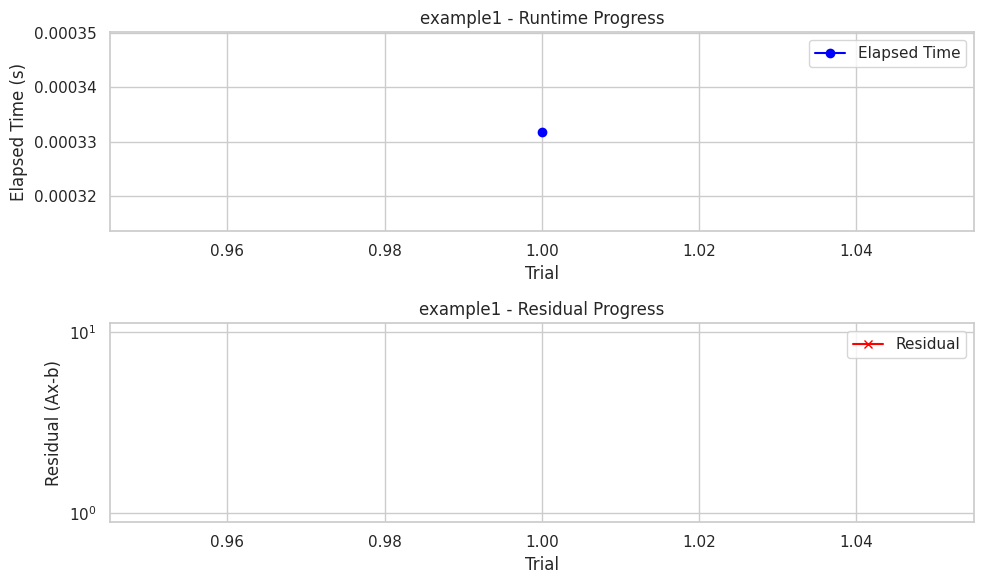

<Figure size 640x480 with 0 Axes>

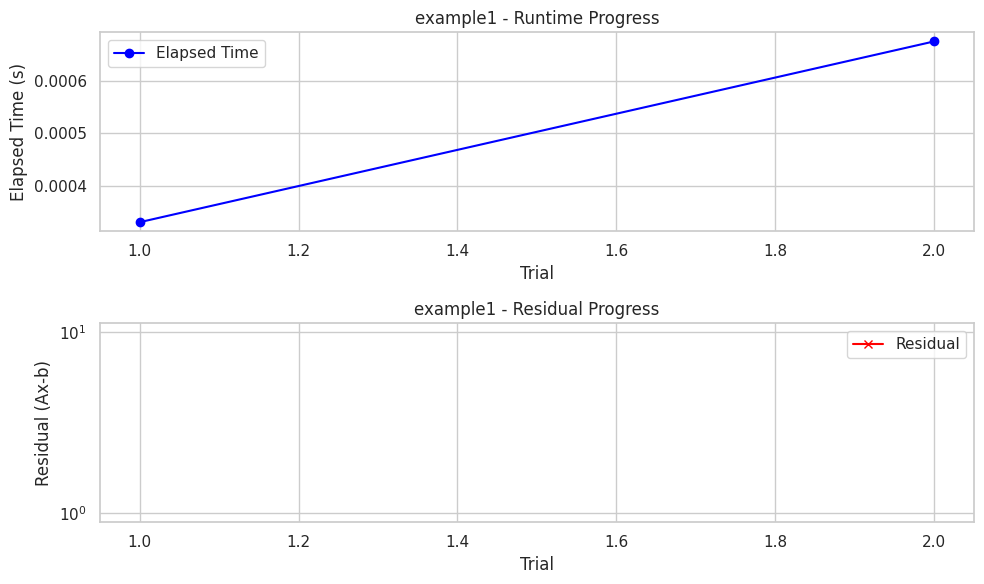

<Figure size 640x480 with 0 Axes>

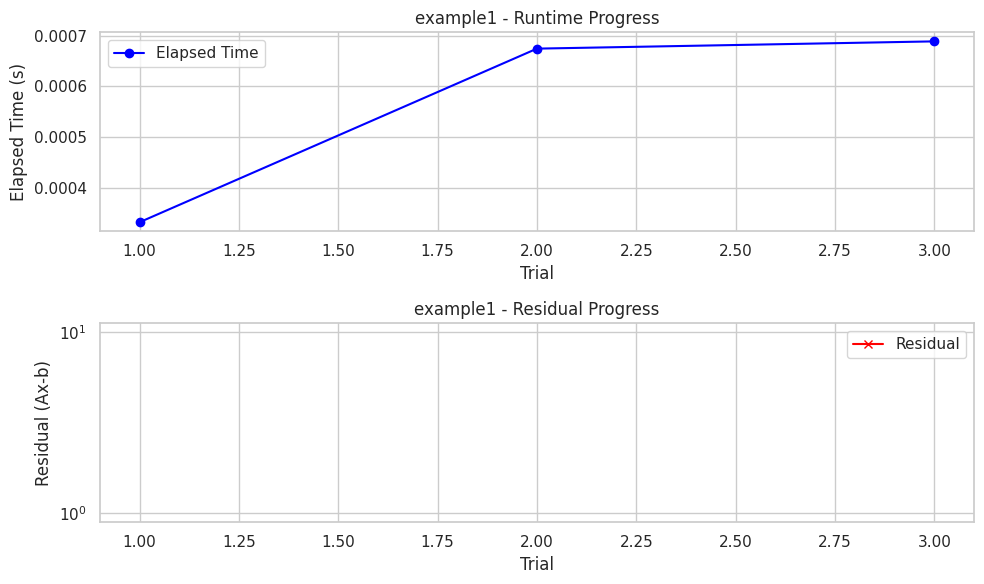

<Figure size 640x480 with 0 Axes>

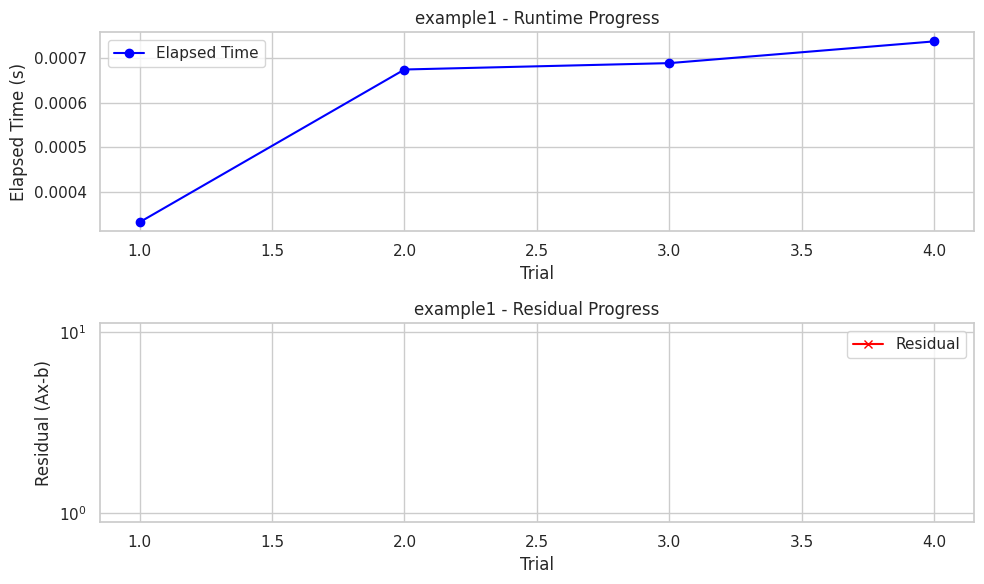

<Figure size 640x480 with 0 Axes>

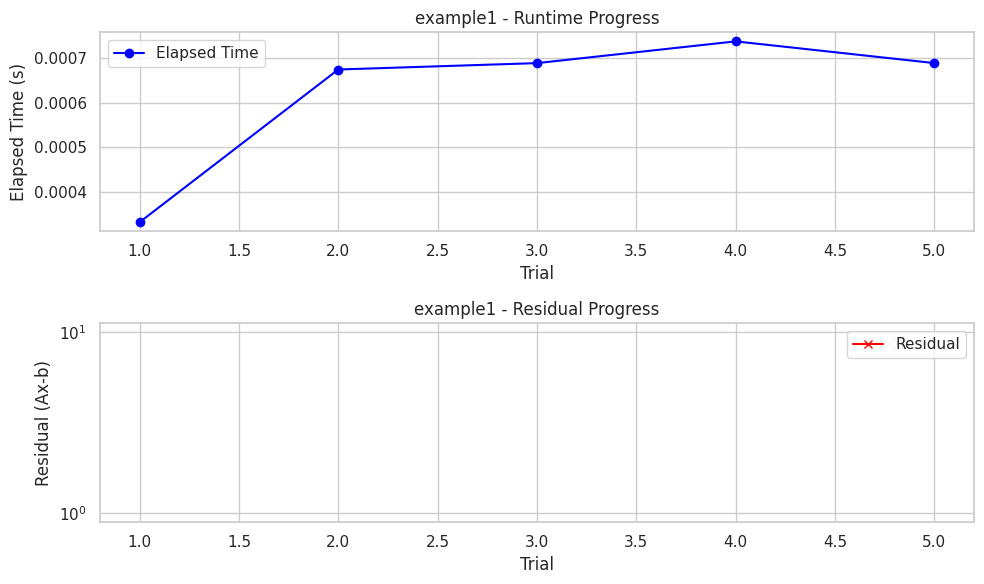

Running problem example2_phaseI


<Figure size 640x480 with 0 Axes>

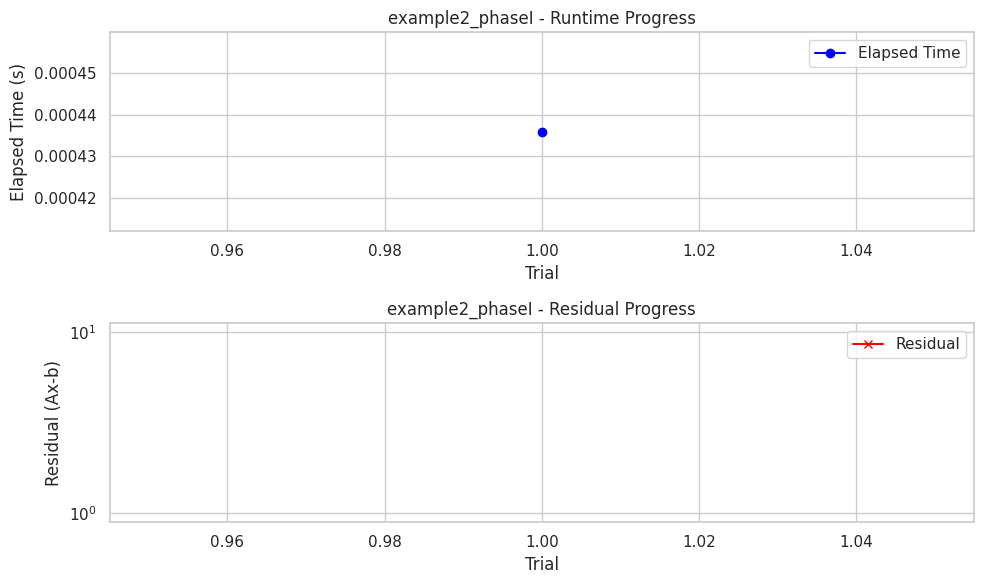

<Figure size 640x480 with 0 Axes>

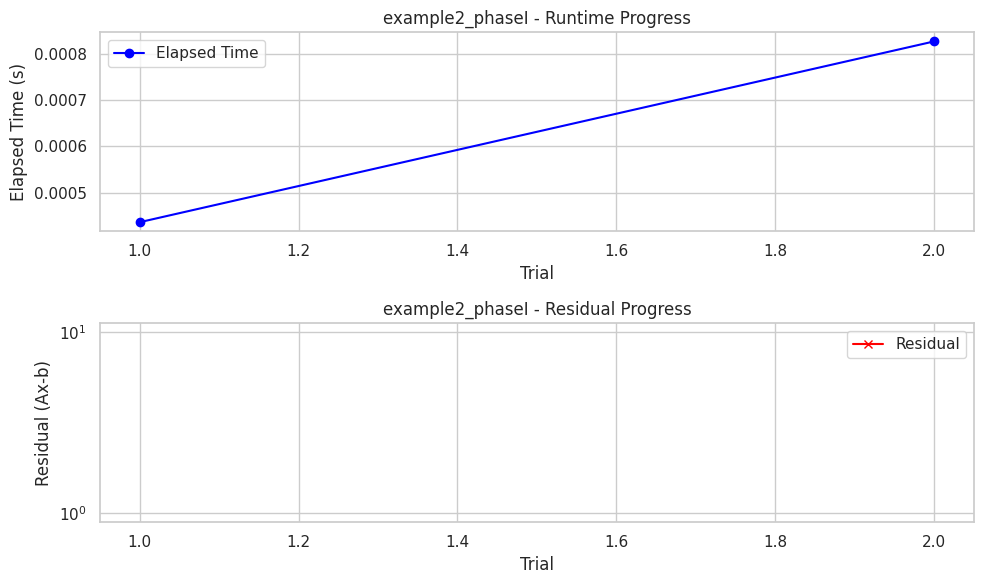

<Figure size 640x480 with 0 Axes>

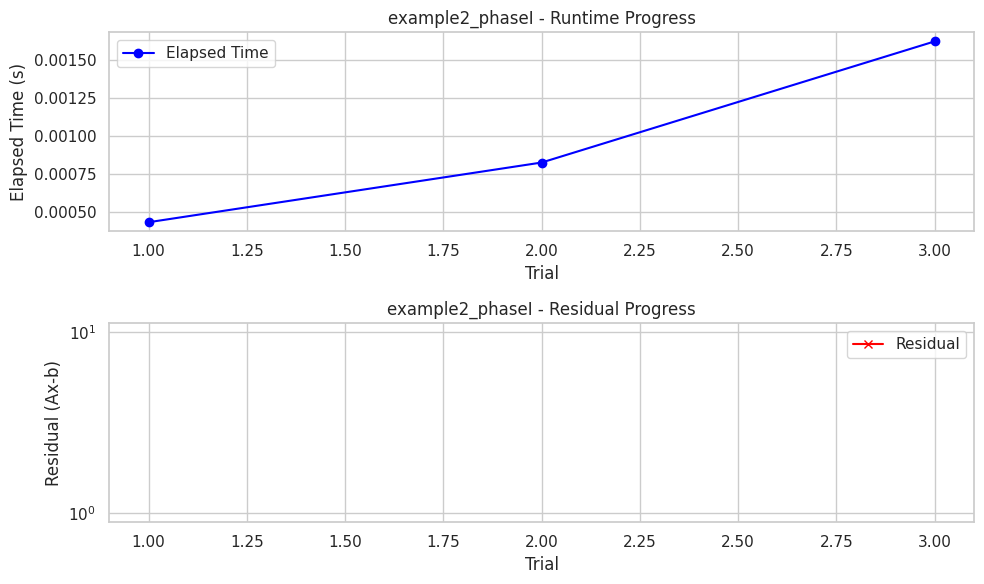

<Figure size 640x480 with 0 Axes>

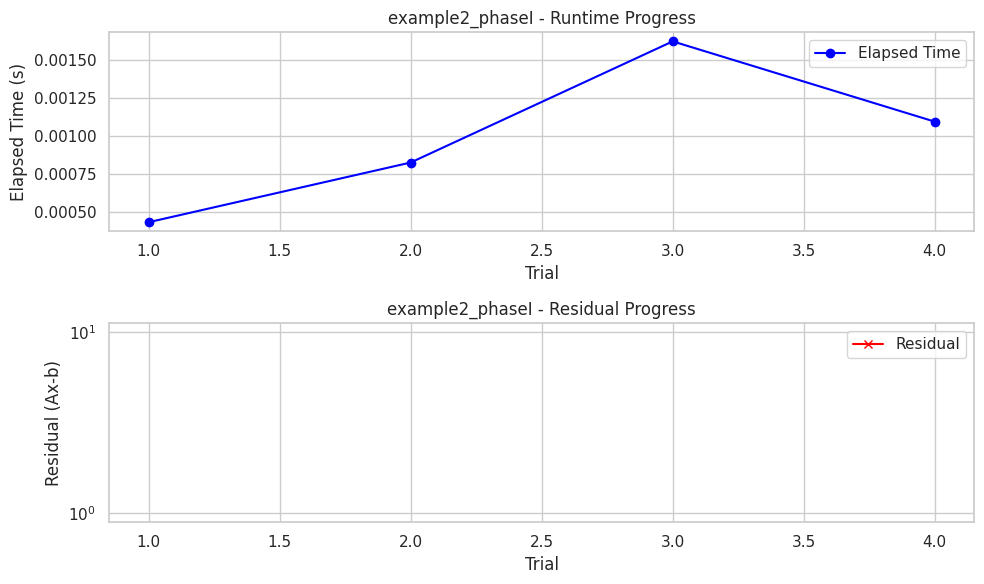

<Figure size 640x480 with 0 Axes>

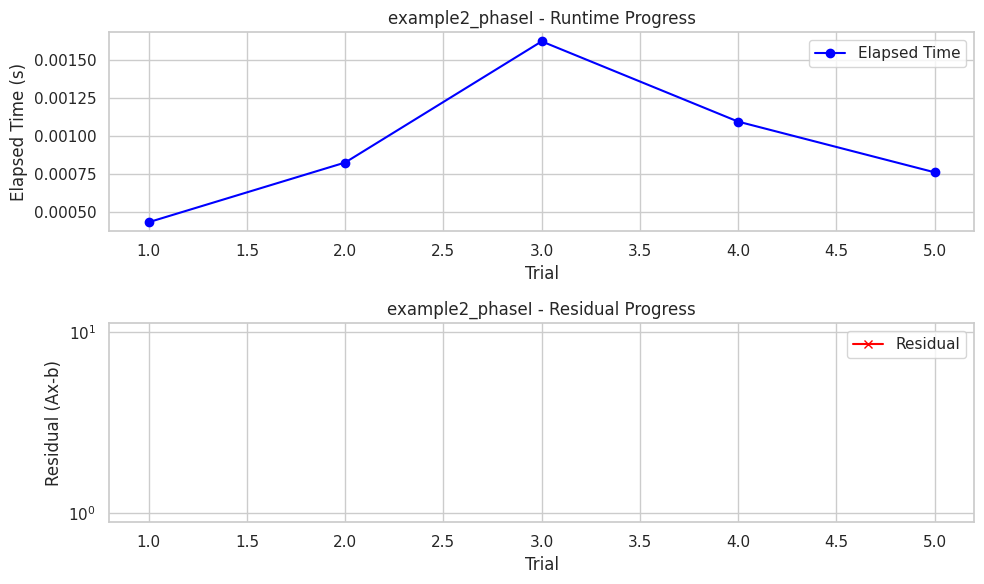

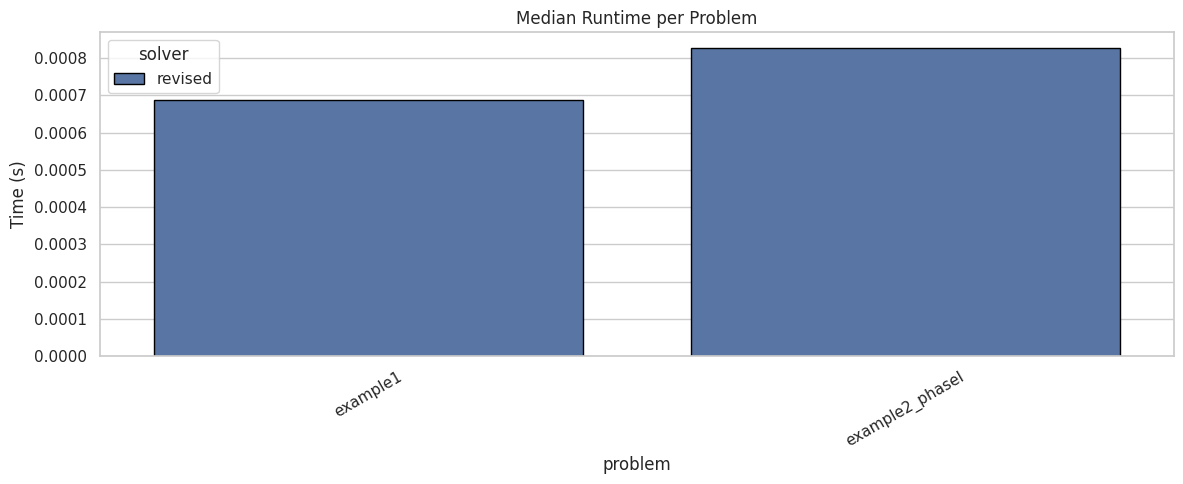

/tmp/ipykernel_8006/4026521236.py:140: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale("log")


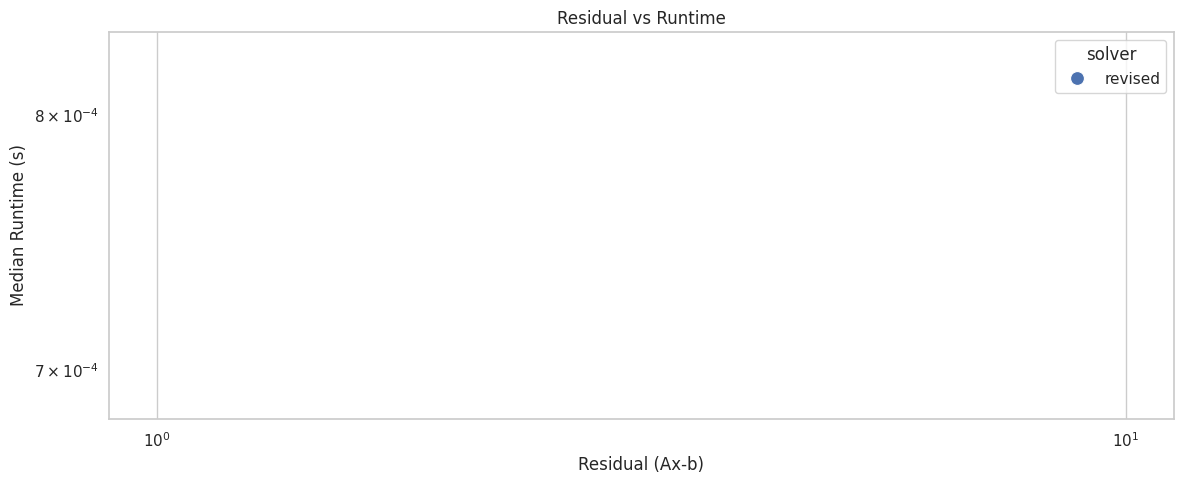

In [37]:
def main():
    args = parse_args()
    if args.results is None:
        results_dir = get_default_results_dir()
    else:
        results_dir = args.results
    logger.info("Results directory: %s", results_dir)
    run_all(repeats=args.repeats, warmup=args.warmup, results_dir=results_dir)


if __name__ == "__main__":
    main()
